# [Bonus Tasks](svm_segm.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.ndimage as ndi
import skimage.morphology as morph
import skimage.util
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
def blend_result(img, seg, border_radius=1, interior_opacity=1, interior_opacity_decay=0.9, color=(0,1,0)):
    img  = np.dstack([img] * 3).copy()
    img -= img.min()
    img /= img.max()
    selem  = morph.disk(border_radius)
    seg_bd = np.logical_xor(morph.binary_dilation(seg, selem), morph.binary_erosion(seg, selem))
    mask_decay = ndi.distance_transform_edt(seg)
    for i in range(3):
        opacity = interior_opacity / pow(1 + mask_decay[seg], interior_opacity_decay)
        img[:,:,i][seg] = color[i] * opacity + (1 - opacity) * img[:,:,i][seg]
        img[:,:,i][seg_bd] = color[i]
    return img

In [3]:
patch_sizes = (16, 16)
patch_height, patch_width = patch_sizes
step = patch_width // 2

---

**[Task 1.1.]()** Implement `create_data_matrix`:

In [4]:
def create_data_matrix(img) :
    patches = skimage.util.view_as_windows(img, window_shape = patch_sizes, step = step)
    num_patches = patches.shape[0] * patches.shape[1]
    X = patches.reshape(num_patches, -1)
    
    return np.array(X)

Test:

In [ ]:
'''
img = plt.imread(f'data/NIH3T3/im/dna-0.png')
view = skimage.util.view_as_windows(img, window_shape = patch_sizes, step = step)
print(view.shape)
'''


(127, 167, 16, 16)


**[Task 1.2.]()** Implement `create_gt_labels_vector`:

In [6]:
def create_gt_labels_vector(img) :
    patches = skimage.util.view_as_windows(img, window_shape = patch_sizes, step = step)
    num_patches = patches.shape[0] * patches.shape[1]
    
    #y = np.zeros(num_patches, dtype = np.int32)
    y = []

    for i in range(patches.shape[0]) :
        for j in range(patches.shape[1]) :
            patch = patches[i, j]

            if np.mean(patch) > 0.5 :
                y.append(1)
            
            elif np.mean(patch) == 0 :
                y.append(-1)
            
            else :
                y.append(0)

    return np.array(y)

Test:

In [ ]:
'''
gt = plt.imread('data/NIH3T3/gt/33.png')

patches = skimage.util.view_as_windows(gt, window_shape = patch_sizes, step = step)
#patches = skimage.util.view_as_blocks(img, block_shape=patch_sizes)
comb = []

for i in range(patches.shape[0]) :
        for j in range(patches.shape[1]) :
            patch = patches[i, j]
            comb.append(np.mean(patch))

print(min(comb))



view_Y = create_gt_labels_vector(gt)

print(view_Y.shape)
'''


0.0
(21209,)


**[Task 1.3.]()** Create the SVM classifier:

In [8]:
clf = make_pipeline(StandardScaler(), SVC(class_weight='balanced', gamma=0.1))

**[Task 1.3 (a).]()** Create the data matrices for the images `dna-33` and `dna-44`:

In [9]:
dna_33 = plt.imread('data/NIH3T3/im/dna-33.png')
dna_44 = plt.imread('data/NIH3T3/im/dna-44.png')

X_33 = create_data_matrix(dna_33)
X_44 = create_data_matrix(dna_44)

#print(X_33)

**[Task 1.3 (b).]()** Create the corresponding ground truth label vectors:

In [10]:
ground_33 = plt.imread('data/NIH3T3/gt/33.png')
ground_44 = plt.imread('data/NIH3T3/gt/44.png')

Y_33 = create_gt_labels_vector(ground_33)
Y_44 = create_gt_labels_vector(ground_44)

**[Task 1.3 (c).]()** Create the *combined* data matrices and ground truth label vectors:

In [11]:
X_valid = np.concatenate([X_33[Y_33 != 0], X_44[Y_44 != 0]])
Y_valid = np.concatenate([Y_33[Y_33 != 0], Y_44[Y_44 != 0]])


**[Task 1.3 (d).]()** Train the classifier using the data matrix and label vectors from above:

In [12]:
clf.fit(X_valid, Y_valid)    

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(class_weight='balanced', gamma=0.1))])

**[Task 1.4.]()** Implement the function `predict_image`:

In [ ]:
def predict_image(img) :
    # get the matrix from the image
    X = create_data_matrix(img)
    # predict the labels from the patches (is a vector)
    prediction = clf.predict(X)

    # result image with False at every point
    result = np.zeros(img.shape, dtype=bool)
    
    # view from the result in windows (if changed here, also changed in results)
    patch_height, patch_width = patch_sizes
    step = patch_width // 2
    patches = skimage.util.view_as_windows(result, window_shape = patch_sizes, step = step)

    # the patch with all True values
    t = np.full(patch_sizes, True, dtype=bool)

    # go trough all patches
    for i in range(patches.shape[0]) :
        for n in range(patches.shape[1]) :
            # convert the patch index into the corresponding labels index in the vector
            num = i * patches.shape[1] + n
            # if the label in the prediction is 1, change the patch to all True
            if prediction[num] == 1 :       
                patches[i, n] = t
    

    return result


Tests:

In [ ]:
    '''
    img = plt.imread(f'data/NIH3T3/im/dna-0.png')
    X = create_data_matrix(img)
    prediction = clf.predict(X)

    print(prediction)

    result = np.zeros(img.shape, dtype=bool)
    
    patches = skimage.util.view_as_blocks(result, block_shape = patch_sizes)
    print(patches.shape)


    t = np.full(patch_sizes, True, dtype=bool)
    print(t.shape)

    print(patches[1, 2].shape)
    '''

[ 1  1 -1 ...  1  1  1]


'\nresult = np.zeros(img.shape, dtype=bool)\n\npatches = skimage.util.view_as_blocks(result, block_shape = patch_sizes)\nprint(patches.shape)\n\n\nt = np.full(patch_sizes, True, dtype=bool)\nprint(t.shape)\n\nprint(patches[1, 2].shape)\n'

(21209, 256)


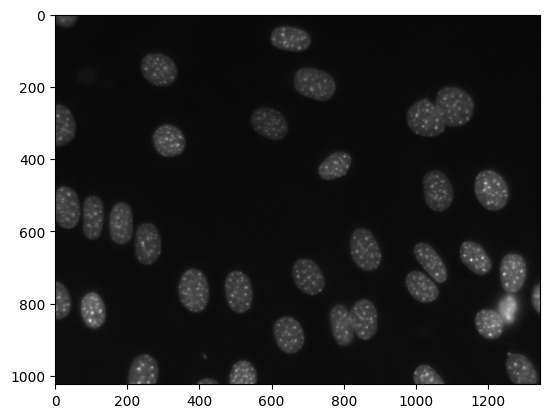

In [15]:
img = plt.imread(f'data/NIH3T3/im/dna-0.png')
plt.imshow(img, 'gray')

X = create_data_matrix(img)
print(X.shape)
#prediction = clf.predict(X)

Test your implementation:

[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]]


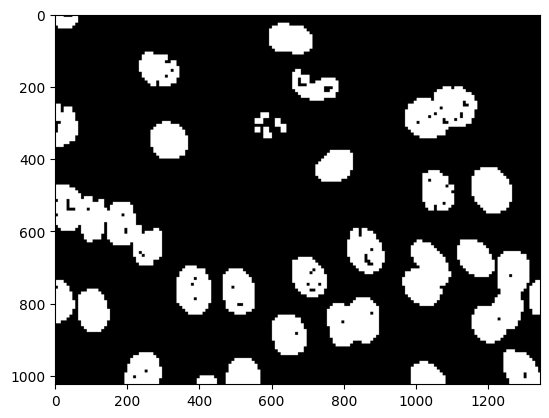

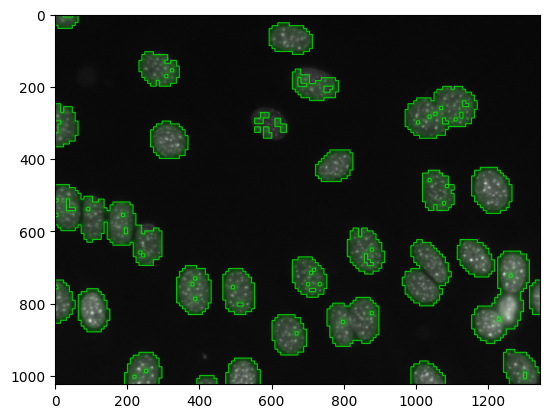

In [16]:
img = plt.imread(f'data/NIH3T3/im/dna-0.png')
seg = predict_image(img)

print(seg)

plt.imshow(seg, vmin=0, vmax=1, cmap='gray')


plt.figure()
plt.imshow(blend_result(img, seg))



**[Task 1.5.]()** Perform batch processing:

In [17]:
seq = [28, 29, 33, 44, 46, 49]

all = []

for i in seq :
    img = plt.imread(f'data/NIH3T3/im/dna-{i}.png')
    ground = plt.imread(f'data/NIH3T3/gt/{i}.png')

    binground = ground > 0.5
    binimg = predict_image(img)
    
    dice = 2 * (binimg * binground).sum() / (binimg.sum() + binground.sum())

    all.append(dice)

    print('image: ' + str(i) + ', Dice: ' + str(round(dice, 2)))

print()
print('Average Dice: ' + str(round(sum(all)/len(all), 2)))



image: 28, Dice: 0.79
image: 29, Dice: 0.73
image: 33, Dice: 0.65
image: 44, Dice: 0.73
image: 46, Dice: 0.63
image: 49, Dice: 0.72

Average Dice: 0.71
